# 이미지 템플릿에 어울리는 요소 찾기
---
문제 정의: 다양한 요소 이미지들 중에서 특정 이미지 템플릿에 가장 적합한 요소를 선택해야 합니다. 해당 이미지 템플릿의 주제, 색상, 스타일 등을 고려하여 가장 어울리는 요소를 이유와 함께 추천합니다.

## 실험 환경
- 이 노트북은 SageMaker Studio Code Editor 및 커널 base (Python 3.10.13) 에서 테스트 되었습니다.
- 실행 환경에 설치된 Python Package 참고 하세요. --> [requirements.txt](../requirements.txt)

## 참고 자료
- [Building with Anthropic’s Claude 3 on Amazon Bedrock and LangChain](https://medium.com/@dminhk/building-with-anthropics-claude-3-on-amazon-bedrock-and-langchain-%EF%B8%8F-2b842f9c0ca8)
- [Amazon Bedrock 기반 Amorepacific 리뷰 요약 서비스 평가 방법 구현하기](langchain_core.runnables.base.RunnableSequence)
- [Amazon Bedrock model IDs](https://docs.aws.amazon.com/bedrock/latest/userguide/model-ids.html)

---

# 1. 환경 셋업

In [1]:
%load_ext autoreload
%autoreload 2

상위 폴더의 경로를 추가하여 해당 유틸리티, 이미지 폴더를 참조 합니다.

In [2]:
import sys, os

def add_python_path(module_path):
    if os.path.abspath(module_path) not in sys.path:
        sys.path.append(os.path.abspath(module_path))
        print(f"python path: {os.path.abspath(module_path)} is added")
    else:
        print(f"python path: {os.path.abspath(module_path)} already exists")
    print("sys.path: ", sys.path)

module_path = ".."
add_python_path(module_path)

python path: /home/sagemaker-user/aws-ai-ml-workshop-kr/genai/aws-gen-ai-kr/20_applications/05_image_styling_recommendation_with_prompt_engineering/evaluation is added
sys.path:  ['/home/sagemaker-user/aws-ai-ml-workshop-kr/genai/aws-gen-ai-kr/20_applications/05_image_styling_recommendation_with_prompt_engineering/evaluation/notebook', '/opt/conda/lib/python310.zip', '/opt/conda/lib/python3.10', '/opt/conda/lib/python3.10/lib-dynload', '', '/opt/conda/lib/python3.10/site-packages', '/home/sagemaker-user/aws-ai-ml-workshop-kr/genai/aws-gen-ai-kr/20_applications/05_image_styling_recommendation_with_prompt_engineering/evaluation']


In [3]:
import os
import boto3
import json
# import eval_utils.bedrock_runtime_wrapper



Amazon Bedrock Claude3 모델을 사용 지역 및 모델 아이디 지정 합니다. 또한 Boto3 SDK 를 활용하는 Client 를 가져 옵니다

In [4]:

region = "us-west-2"
claude3_model_id = "anthropic.claude-3-sonnet-20240229-v1:0"

client = boto3.client(service_name="bedrock-runtime", region_name=region)


# 2. 베이스 이미지 템플릿 보여주기

In [5]:
from eval_utils.util import (
                        set_body,
                        invoke_claude3_sonnet_model, 
                        extract_properties_from_image,
                        encoding_image,
                        get_files_in_folder,
                        parse_output_select_reason
)

## 이미지 경로 로딩 하기

In [7]:
# Get sample directory files

sample_directory = "sample_02"
sample_folder_path = f'../samples/{sample_directory}/'

all_items = get_files_in_folder(folder_path = sample_folder_path)
print(all_items)



{'target': '../samples/sample_02/target_image.png', 'associates': ['../samples/sample_02/candidate_element_4.png', '../samples/sample_02/candidate_element_3.png', '../samples/sample_02/candidate_element_2.png', '../samples/sample_02/candidate_element_1.png']}


## 이미지 로딩 및 속성 추출
- 아래와 같이 프롬프트를 작성하고, 이미지를 로딩하여 속성을 추출 합니다. 
- 첫번째 이미지는 베이스 이미지 템플릿이고, 나머지 4개의 이미지는 베이스 이미지 템플릿에 넣을 요소 이미지 입니다.
    - 원본 이미지의 경로는 아래와 같습니다.
        - 베이스 이미지 템플릿: [파란색의 차분하고 고요한 바다 사진과 감성적인 영어 단어가 적힌 굿즈(판스티커 정사각형)](https://www.miricanvas.com/templates/print_sticker_square/11hvg-파란색의-차분하고-고요한-바다-사진과-감성적인-영어-단어가-적힌-굿즈-정사각형)
        - 후보 요소 1: [국화]
        - 후보 요소 2: [토마토]
        - 후보 요소 3: [열대어]
        - 후보 요소 4: [일렉 기타]

## This is target image
../samples/sample_02/target_image.png


- The model returned 1 response(s):
{
  "설명": "이 이미지는 바다 풍경을 배경으로 하고 있습니다. 수평선 위에 'YOUTH'라는 단어가 반투명한 타원형 모양으로 표시되어 있고, 그 아래에는 'Let you peace of mind'라는 문구가 있습니다. 바다 물결이 잔잔하게 일렁이고 있으며, 전체적으로 차분하고 평화로운 분위기를 자아내고 있습니다.",
  "속성": {
    "배경": "바다",
    "수평선": "있음",
    "문구": "YOUTH, Let you peace of mind",
    "분위기": "평화로움, 차분함"
  }
}


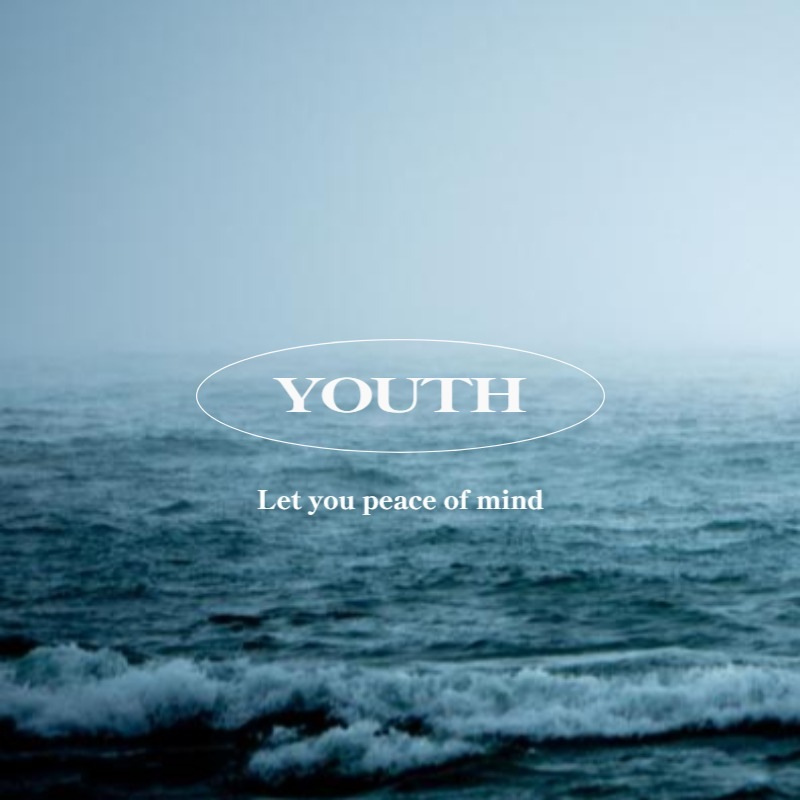

## This is candidate image
- The model returned 1 response(s):
{
  "이미지설명": "전기 기타의 그림",
  "모양": "일반적인 전기 기타 모양",
  "색상": "청록색 계열",
  "스타일": "단순하고 심플한 스타일",
  "용도": "기타 연주를 상징하는 아이콘이나 로고로 사용 가능"
}


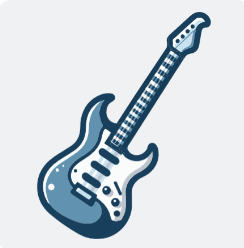

## This is candidate image
- The model returned 1 response(s):
{
  "이미지설명": "노랑과 검은색 줄무늬를 가진 열대어의 그림",
  "생물": "열대어",
  "색상": ["노랑", "검은색"],
  "무늬": "줄무늬",
  "모양": "길쭉하고 구부러진 형태"
}


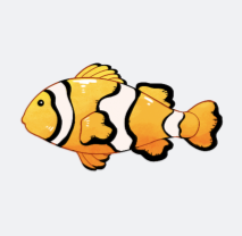

## This is candidate image
- The model returned 1 response(s):
{
  "설명": "이미지는 귀여운 붉은 색 과일 캐릭터를 나타냅니다.",
  "특징": {
    "모양": "둥근 모양의 몸통과 작은 잎사귀 두 개가 있습니다.",
    "표정": "몸통 중앙에 작은 반원 모양의 입과 점으로 된 눈이 있어 귀여운 표정을 지었습니다.",
    "색상": "주된 색상은 붉은색이며 잎사귀는 녹색입니다."
  }
}


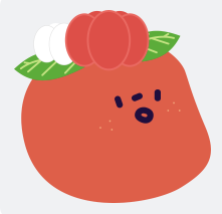

## This is candidate image
- The model returned 1 response(s):
{
  "설명": "이 이미지는 노란색 국화 꽃송이들이 가지 위에 피어있는 모습을 보여줍니다. 잎사귀들도 함께 있어 가을의 분위기를 자아냅니다.",
  "속성": {
    "꽃": "국화",
    "꽃색깔": "노란색",
    "가지": "있음",
    "잎사귀": "있음",
    "계절": "가을"
  }
}


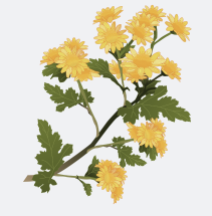

In [10]:
# invoke bedrock
# simple prompt

multimodal_text_prompt = "Extract the properties and description of this image as JSON in Korean."

target, associates = extract_properties_from_image(all_items,client,claude3_model_id,multimodal_text_prompt)                

## This is target image
../samples/sample_02/target_image.png


- The model returned 1 response(s):
{
  "주요 시각 요소": {
    "이미지": "바다 풍경을 배경으로 하는 단순한 구성",
    "텍스트": "'YOUTH'라는 단어와 'Let you peace of mind'라는 문구가 포함됨",
    "색상": "바다의 차가운 블루 톤과 하늘의 연한 블루 톤이 주를 이룸"
  },
  "속성": {
    "심플함": "최소한의 요소로 구성되어 있어 깔끔하고 단순한 느낌을 줌",
    "평화로움": "바다 풍경과 부드러운 색조가 차분하고 평화로운 분위기를 자아냄"
  },
  "감정적 영향": {
    "휴식": "바다 풍경이 주는 여유로움과 평화로움으로 인해 휴식과 안식을 연상시킴",
    "자유": "넓고 열린 바다가 주는 자유로움과 해방감을 느낄 수 있음"
  },
  "문화적 의미": {
    "청춘": "'YOUTH'라는 단어가 젊음과 활력을 상징함",
    "평화": "바다는 평화와 조화로움을 대표하는 자연 요소임"
  },
  "기술적 세부사항": {
    "해상도": "고해상도 이미지로 선명한 화질을 보여줌",
    "투명 텍스트": "텍스트가 반투명 효과로 처리되어 자연스럽게 이미지와 어우러짐"
  },
  "접근성 기능": {
    "높은 대비": "텍스트와 배경 간의 대비가 높아 가독성이 좋음",
    "간단한 레이아웃": "단순한 구성으로 인해 시각적 복잡성이 낮아 접근성이 좋음"
  },
  "잠재적 활용": {
    "웹/모바일": "청춘, 휴식, 자유 등의 컨셉을 활용한 웹/모바일 광고 및 프로모션",
    "인쇄물": "평화로운 분위기를 활용한 리조트, 여행사 등의 인쇄 광고 및 브로셔",
    "브랜딩": "젊고 자유로운 이미지를 원하는 브랜드의 비주얼 아이덴티티 요소로 활용 가능"
  }
}


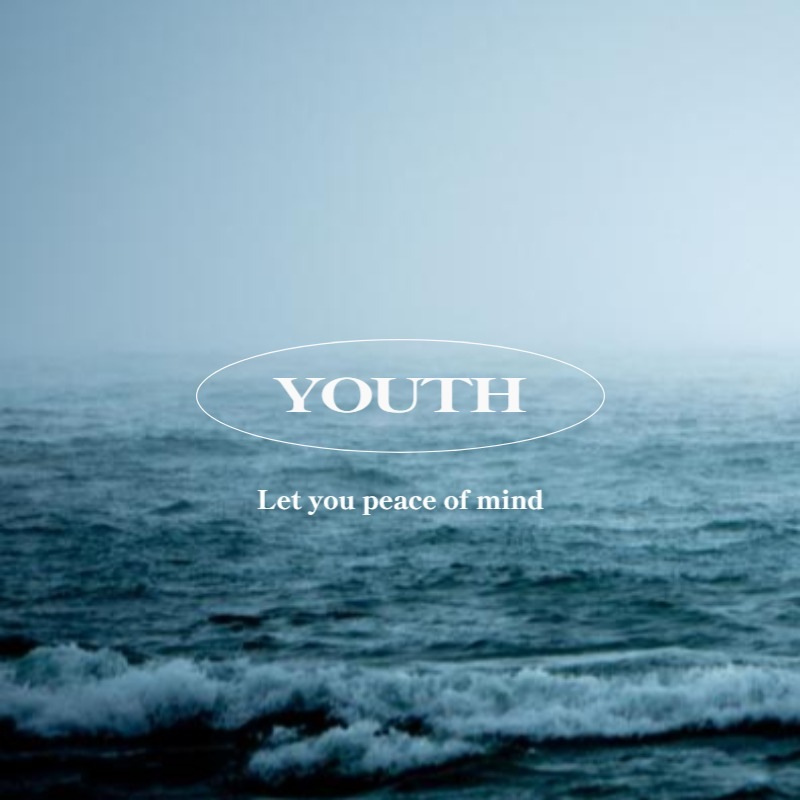

## This is candidate image
- The model returned 1 response(s):
이미지 분석 결과는 다음과 같습니다:

{
  "주요 시각 요소": {
    "설명": "이미지는 전기 기타의 실루엣을 단순화한 형태입니다. 기타 바디와 넥, 픽업, 브릿지 등의 기본 구성 요소가 포함되어 있습니다."
  },
  "속성": {
    "색상": "남색 계열의 단일 색상으로 구성되어 있습니다.",
    "스타일": "평면 디자인 스타일로 세부 묘사 없이 간결하고 심플한 모습입니다."
  },
  "감정적 영향": {
    "설명": "록 음악과 젊음의 활력을 상징하여 역동적이고 열정적인 느낌을 줍니다. 단순한 형태이지만 친숙하고 즐거운 이미지입니다."
  },
  "문화적 의미": {
    "설명": "전기 기타는 록, 메탈, 팝 등 대중 음악 장르의 상징적 악기로, 젊은 세대의 음악 문화를 대표합니다."
  },
  "기술적 세부사항": {
    "형식": "벡터 그래픽 형식으로 추정됩니다.",
    "크기": "해상도 독립적이므로 다양한 크기로 확대/축소가 가능합니다."
  },
  "접근성 기능": {
    "설명": "단색 실루엣 형태이므로 색맹 사용자에게도 잘 인식될 수 있습니다."
  },
  "잠재적 활용 분야": {
    "설명": "음악, 엔터테인먼트, 청년 문화 관련 디자인에 활용 가능합니다. 웹/모바일 앱 아이콘, 로고, 브랜딩, 마케팅 자료 등 다양한 매체에 적용할 수 있습니다."
  }
}


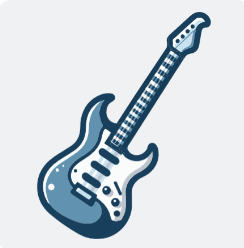

## This is candidate image
- The model returned 1 response(s):
{
  "시각적 요소": {
    "주제": "열대어",
    "형태": "만화 스타일의 단순화된 물고기 형상",
    "색상": "주황색과 검은색 줄무늬 패턴"
  },
  "속성": {
    "재미있는": "친근하고 유머러스한 디자인",
    "단순한": "세부 묘사 없이 기본 형태로 표현"
  },
  "감정적 영향": {
    "즐거움": "밝고 활기찬 색상과 디자인으로 긍정적인 느낌 전달",
    "친근함": "만화 스타일로 인해 대중적이고 접근하기 쉬운 이미지"
  },
  "문화적 의미": {
    "대중문화": "대중에게 친숙한 열대어 모티프를 활용한 디자인",
    "아이콘화": "단순화된 형태로 상징성과 식별성이 높음"
  },
  "기술 세부사항": {
    "벡터 그래픽": "선과 면으로 구성된 벡터 이미지 형식",
    "확장성": "해상도에 구애받지 않고 다양한 크기로 확대/축소 가능"
  },
  "접근성 기능": {
    "높은 대비": "주황색과 검은색의 대비로 가시성이 좋음",
    "단순한 형태": "복잡한 디테일 없이 인지하기 쉬운 디자인"
  },
  "잠재적 용도": {
    "마스코트/아이콘": "제품, 서비스, 브랜드 등의 대표 이미지로 활용 가능",
    "장식": "패턴, 프린트, 벽지 등의 디자인 요소로 사용 가능",
    "교육": "어린이 교재나 학습 자료의 시각적 보조 수단"
  }
}


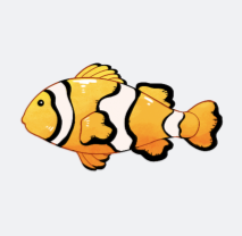

## This is candidate image
- The model returned 1 response(s):
{
  "시각적 요소": {
    "주요 형태": "토마토의 단순화된 형태",
    "색상": "주황색과 빨간색 계열의 색상 사용",
    "세부 요소": "잎새 2개, 작은 미소 표정"
  },
  "속성": {
    "스타일": "단순하고 만화 같은 스타일",
    "친근감": "귀여운 표정으로 친근한 이미지 전달"
  },
  "감정적 영향": {
    "긍정적 느낌": "단순하고 귀여운 디자인으로 부드럽고 편안한 느낌 자아냄",
    "친숙함": "일상에서 쉽게 접할 수 있는 토마토를 소재로 하여 친숙함 유발"
  },
  "문화적 의미": {
    "식문화 상징": "토마토는 전 세계적으로 널리 사용되는 식재료로 다양한 문화권에서 의미 있음"
  },
  "기술적 세부사항": {
    "형식": "PNG 또는 벡터 형식으로 추정",
    "해상도": "낮은 해상도의 단순한 이미지"
  },
  "접근성 기능": {
    "대체 텍스트": "시각 장애인을 위한 적절한 대체 텍스트 제공 필요"
  },
  "잠재적 활용 분야": {
    "웹/모바일 앱": "아이콘, 마스코트, 일러스트레이션 등으로 활용 가능",
    "인쇄물": "메뉴, 포장지, 광고 등에 사용 가능",
    "제품 디자인": "식품 관련 제품의 패키지 디자인에 활용 가능"
  }
}


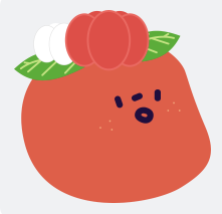

## This is candidate image
- The model returned 1 response(s):
{
  "이미지분석": {
    "시각적요소": {
      "설명": "노란색 국화 꽃송이들이 줄기에 달려있고, 녹색 잎사귀들이 함께 있는 식물 이미지입니다."
    },
    "속성": {
      "색상": "노란색, 녹색",
      "모양": "꽃송이는 작고 동그란 모양, 잎사귀는 거칠고 깊게 패인 모양"
    },
    "감정적영향": {
      "설명": "국화는 가을의 상징으로 여겨지며 이 이미지는 평화로움과 고요함을 전달합니다. 또한 자연의 아름다움과 생명력을 느낄 수 있습니다."
    },
    "문화적의미": {
      "설명": "국화는 한국을 비롯한 동아시아 문화에서 장수와 불멸을 상징하는 꽃으로 여겨집니다. 또한 가을의 정취를 대표하는 꽃입니다."
    },
    "기술적세부사항": {
      "해상도": "이미지 해상도는 중간 정도입니다.",
      "형식": "JPG 또는 PNG 형식으로 추정됩니다."
    },
    "접근성기능": {
      "설명": "이미지에는 시각장애인을 위한 대체 텍스트 설명이 필요할 것으로 보입니다."
    },
    "활용분야": {
      "설명": "이 이미지는 가을 시즌 상품 마케팅, 자연 테마 디자인, 꽃 일러스트레이션, 교육 자료 등 다양한 분야에서 활용될 수 있습니다."
    }
  }
}


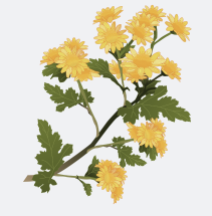

In [30]:
# invoke bedrock
# advance prompt

multimodal_text_prompt = "As a graphic designer, closely examine the given target image, \
    identify its key visual elements, attributes, emotional impact, cultural significance, technical details, accessibility features, \
        and potential applications across various platforms and media, \
            providing a comprehensive analysis in a structured JSON format and in Korean, \
                with detailed descriptions for each identified aspect to inform the effective integration and presentation of the image."


target, associates = extract_properties_from_image(all_items,client,claude3_model_id,multimodal_text_prompt)      

# 3. 어울리는 요소 선택 및 이유 설명

## 프롬프트 작성

In [36]:
image_expert_prompt = f"""Imagine you are a graphic designer tasked with creating a visually appealing and \
effective image template for a client. This template will serve as the foundation for various marketing materials, \
such as brochures, social media posts, and website banners. \
When selecting an element from <associate_element> that complements <target_image>, \
you should consider factors such as similar aesthetic appeal and similarity in the message conveyed by the <target_image>.
Once you have considered these factors, describe the element you would recommend for the base image template. \
Explain why you believe it fits best and how it aligns with base image template. \
Remember to provide a clear and compelling rationale for your recommendation.

Instructions:
1. Please respond in structed JSON format in Korean and without <output> tag.
2. Refer to the structure as below in <output_example>, but exclude the <output_example> tags themselves.    
3. Write "selected_element" in the form of summary simple as possible
4. Write "selected_image_path" given your selection from the <associate_element> list

<target_image>
{str(target)}
</target_image> 

<associate_element>
{str(associates)}
</associate_element>

<output_example>
"selected_image_path" : "candidate_element.jpg"
"reason" :
</output_example>
"""

## Claude3 Sonnet 모델로 요소 선택 및 이유 설명

In [43]:
claude3_model_id = "anthropic.claude-3-sonnet-20240229-v1:0"
response = invoke_claude3_sonnet_model(client = client, claude3_model_id = claude3_model_id,
                            prompt = image_expert_prompt, image = None, multimodal=False)

[autoreload of botocore.exceptions failed: Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/opt/conda/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 475, in superreload
    module = reload(module)
  File "/opt/conda/lib/python3.10/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 619, in _exec
  File "<frozen importlib._bootstrap_external>", line 883, in exec_module
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/opt/conda/lib/python3.10/site-packages/botocore/exceptions.py", line 129, in <module>
    class SSLError(ConnectionError, requests.exceptions.SSLError):
AttributeError: module 'botocore.vendored.requests' has no attribute 'exceptions'
]
[autoreload of boto3.exceptions failed: Traceback (most recent call 

AttributeError: module 'botocore' has no attribute 'auth'

Sonnet이 선택한 이유만을 변수에 넣고 보여주기

In [38]:
from eval_utils.util import print_ww
select_reason_sonnet =  parse_output_select_reason(response)    
print_ww(select_reason_sonnet)


전기 기타 실루엣 이미지는 청춘과 활력, 자유로움을 상징하는 <target_image>의 메시지와 잘 어울립니다. 단순하고 심플한 디자인으로 <target_image>의 미니멀한
스타일과도 조화를 이룹니다. 또한 음악과 젊은 문화를 대표하는 요소로서 <target_image>의 '청춘'이라는 키워드와 연관성이 높습니다. 따라서 이 이미지는
<target_image>의 컨셉과 미학적 특성을 잘 보완할 수 있을 것으로 판단됩니다.


## Claude3 Haiku 모델로 이미지 선택 및 이유 설명

In [39]:
claude3_model_id = "anthropic.claude-3-haiku-20240307-v1:0"
response = invoke_claude3_sonnet_model(client = client, claude3_model_id = claude3_model_id,
                            prompt = image_expert_prompt, image = None, multimodal=False)

- The model returned 1 response(s):
{
  "selected_element": "전기 기타 실루엣 이미지",
  "selected_image_path": "../samples/sample_02/candidate_element_4.png",
  "reason": 
  "이 전기 기타 실루엣 이미지는 <target_image>의 주요 시각 요소와 잘 어울립니다. 두 이미지 모두 단순하고 심플한 스타일로 구성되어 있어 전체적인 미적 일관성을 유지할 수 있습니다. 또한 전기 기타는 젊음과 활력을 상징하는 악기로, <target_image>에서 강조하는 '청춘'이라는 메시지와도 잘 부합합니다. 이 이미지는 다양한 매체에 활용할 수 있는 범용성과 확장성을 가지고 있어, 마케팅 자료 및 브랜딩 등에 효과적으로 사용될 수 있을 것으로 판단됩니다."
}


Haiku가 선택한 이유만을 변수에 넣고 보여주기

In [40]:
select_reason_haiku = parse_output_select_reason(response)    
print_ww(select_reason_haiku)

이 전기 기타 실루엣 이미지는 <target_image>의 주요 시각 요소와 잘 어울립니다. 두 이미지 모두 단순하고 심플한 스타일로 구성되어 있어 전체적인 미적 일관성을 유지할
수 있습니다. 또한 전기 기타는 젊음과 활력을 상징하는 악기로, <target_image>에서 강조하는 '청춘'이라는 메시지와도 잘 부합합니다. 이 이미지는 다양한 매체에 활용할
수 있는 범용성과 확장성을 가지고 있어, 마케팅 자료 및 브랜딩 등에 효과적으로 사용될 수 있을 것으로 판단됩니다.


## Sonnet & Haiku 이유 비교

In [41]:
print("## Claude3 Sonnet")
print_ww(select_reason_sonnet)
print("\n## Claude3 Haiku")
print_ww(select_reason_haiku)

## Claude3 Sonnet
전기 기타 실루엣 이미지는 청춘과 활력, 자유로움을 상징하는 <target_image>의 메시지와 잘 어울립니다. 단순하고 심플한 디자인으로 <target_image>의 미니멀한
스타일과도 조화를 이룹니다. 또한 음악과 젊은 문화를 대표하는 요소로서 <target_image>의 '청춘'이라는 키워드와 연관성이 높습니다. 따라서 이 이미지는
<target_image>의 컨셉과 미학적 특성을 잘 보완할 수 있을 것으로 판단됩니다.

## Claude3 Haiku
이 전기 기타 실루엣 이미지는 <target_image>의 주요 시각 요소와 잘 어울립니다. 두 이미지 모두 단순하고 심플한 스타일로 구성되어 있어 전체적인 미적 일관성을 유지할
수 있습니다. 또한 전기 기타는 젊음과 활력을 상징하는 악기로, <target_image>에서 강조하는 '청춘'이라는 메시지와도 잘 부합합니다. 이 이미지는 다양한 매체에 활용할
수 있는 범용성과 확장성을 가지고 있어, 마케팅 자료 및 브랜딩 등에 효과적으로 사용될 수 있을 것으로 판단됩니다.


In [42]:
%store select_reason_sonnet
%store select_reason_haiku

Stored 'select_reason_sonnet' (str)
Stored 'select_reason_haiku' (str)


# 다음 노트북을 실행 하세요
- [04_matching_reason_evaluation.ipynb](04_matching_reason_evaluation.ipynb)